## **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import xgboost as xgb

In [146]:
from sklearn.metrics import mean_squared_error

## **Datos**

In [149]:
df = pd.read_csv('./Data/Hourly_Energy_Consumption/PJME_hourly.csv')

In [150]:
df.set_index('Datetime', inplace=True)

In [151]:
df.index = pd.to_datetime(df.index)

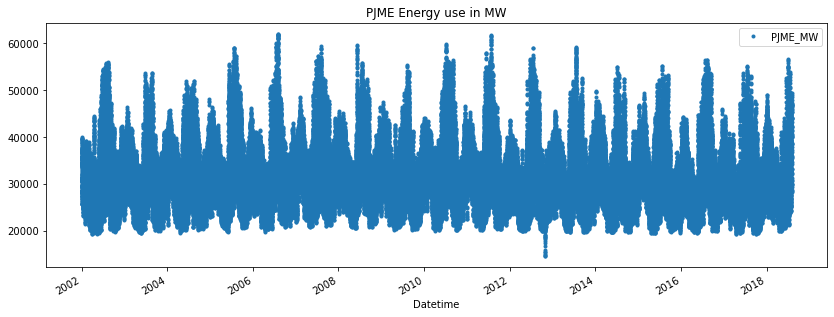

In [152]:
df.plot(
    figsize=(14, 5), 
    style='.',
    title='PJME Energy use in MW'
)

plt.show()

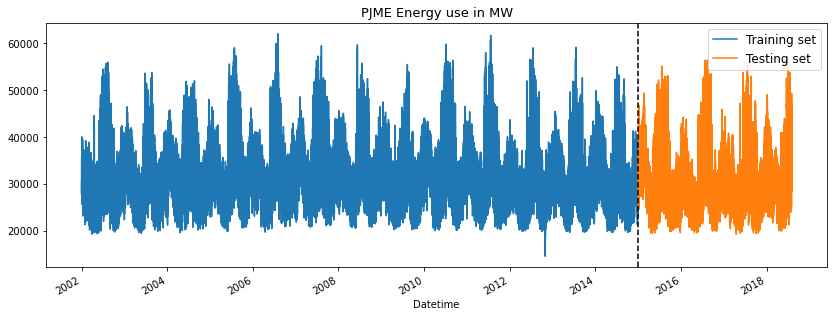

In [154]:
fig, ax = plt.subplots(figsize=(14,5))

plt.title('PJME Energy use in MW', fontsize=13)

train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Testing set')

ax.axvline('01/01/2015', color='black', ls='--')

ax.legend(['Training set', 'Testing set'], loc='upper right', fontsize=12)

plt.show()

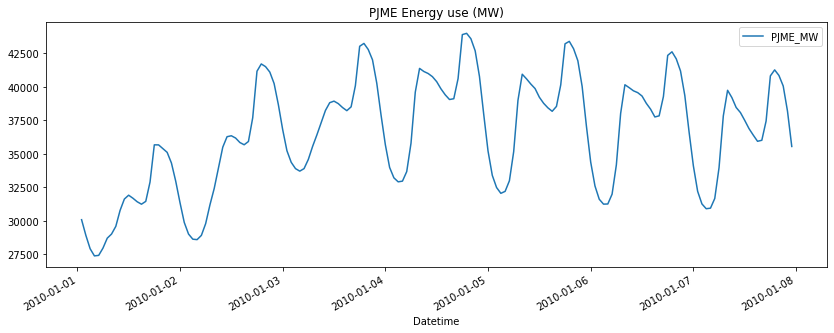

In [155]:
df.query('index > "01/01/2010" & index < "01/08/2010"').plot(
    figsize=(14, 5), 
    title='PJME Energy use (MW)'
)

plt.show()

### **Feature creation**

In [97]:
def create_features(df):
    '''
    Create time series features based on time series index.
    '''
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.day_of_year
    df['dayofweek'] = df.index.day_of_week
    df['hour'] = df.index.hour
    
    return df

In [212]:
df = create_features(df)

#### **Visualize our Feature**

In [141]:
def consumption_by(df, temporality):
    fig, ax = plt.subplots(figsize=(14, 5))

    plt.grid(visible=True, linewidth=0.1, color='white')
    fig.patch.set_facecolor('#21252b') 
    #ax.set_facecolor('#282c34') 
    
    plt.title(f'PJME Energy use in MW by {temporality}', fontsize=13, color='white')

    sns.boxplot(
        data = df,
        x = temporality,
        y = 'PJME_MW'
    )
    
    plt.xlabel(f'{temporality.capitalize()}', size=12, weight=400, color='white')
    plt.xticks(color='white', size=12)

    plt.ylabel('PJME (MW)', size=12, weight=400, color='white')
    plt.yticks(color='white', size=12)

    plt.show()

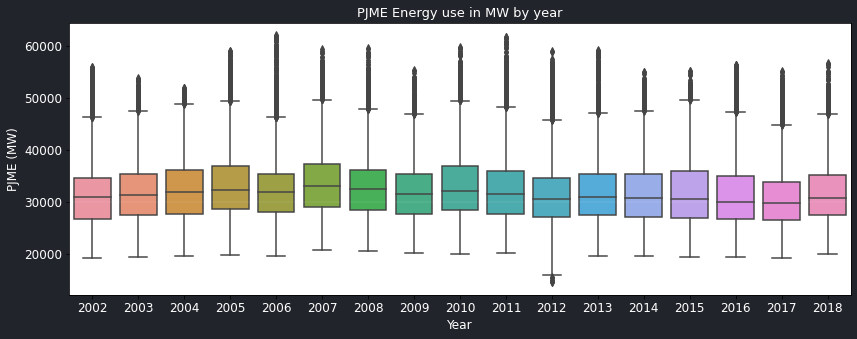

In [142]:
consumption_by(df, 'year')

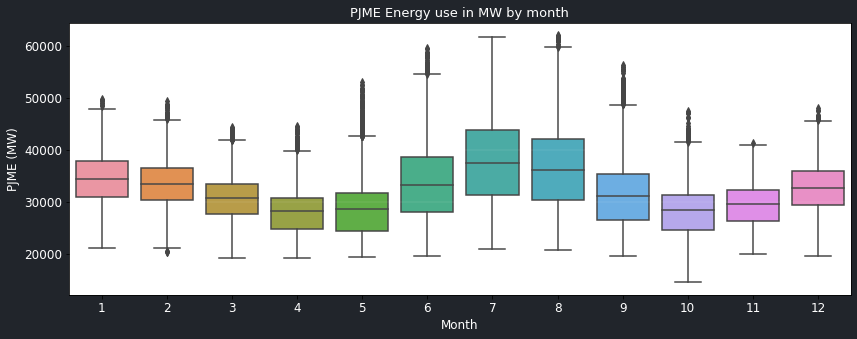

In [143]:
consumption_by(df, 'month')

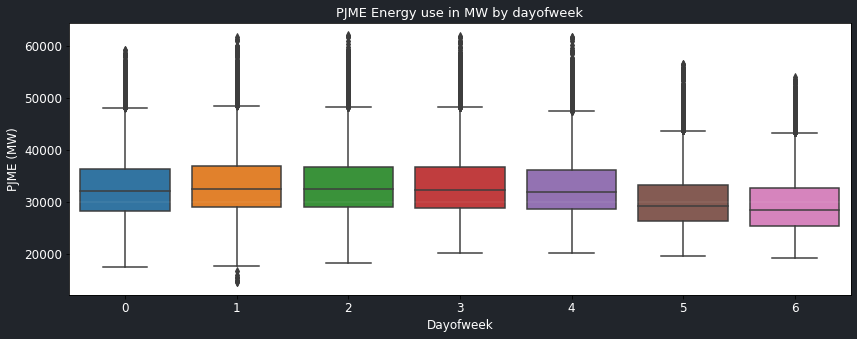

In [144]:
consumption_by(df, 'dayofweek')

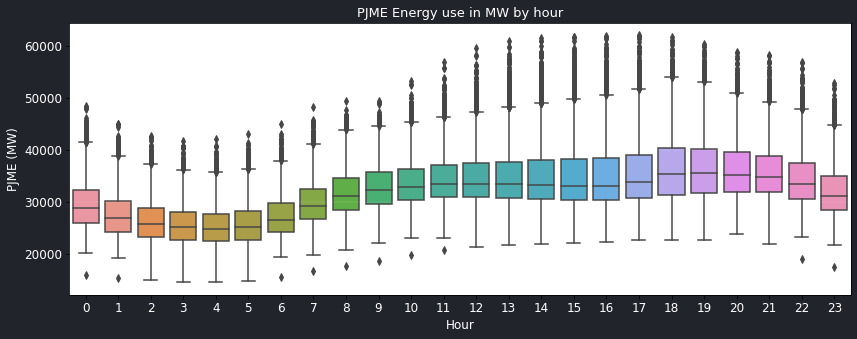

In [145]:
consumption_by(df, 'hour')

### **Train/Test Split**

In [156]:
train = df.loc[df.index < '01/01/2015'].copy()
train = create_features(train)

In [158]:
train.sample()

,PJME_MW,year,month,quarter,dayofyear,dayofweek,hour
Datetime,,,,,,,
2008-07-05 13:00:00,35450.0,2008,7,3,187,5,13


In [157]:
test = df.loc[df.index >= '01/01/2015'].copy()
test = create_features(test)

In [159]:
test.sample()

,PJME_MW,year,month,quarter,dayofyear,dayofweek,hour
Datetime,,,,,,,
2017-05-15 10:00:00,27425.0,2017,5,2,135,0,10


In [161]:
train.columns

Index(['PJME_MW', 'year', 'month', 'quarter', 'dayofyear', 'dayofweek',
       'hour'],
      dtype='object')

In [162]:
FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'dayofweek', 'hour']
TARGET = ['PJME_MW']

In [168]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## **Modelo**

### **Desarrollo**

In [249]:
reg = xgb.XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.01
)

In [250]:
reg.fit(
    X_train, 
    y_train,
    early_stopping_rounds = 50,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose = 100
)

[0]	validation_0-rmse:32601.85156	validation_1-rmse:31654.29688
[100]	validation_0-rmse:12342.12793	validation_1-rmse:11517.66113
[200]	validation_0-rmse:5373.33008	validation_1-rmse:5165.30664
[300]	validation_0-rmse:3375.20654	validation_1-rmse:3829.25439
[400]	validation_0-rmse:2882.54785	validation_1-rmse:3715.20606
[436]	validation_0-rmse:2795.05005	validation_1-rmse:3726.62109


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### **Feature Importance**

In [251]:
f1 = pd.DataFrame(
    zip(X_train.columns, reg.feature_importances_),
    columns=['Feature', 'Importance']
).sort_values('Importance')

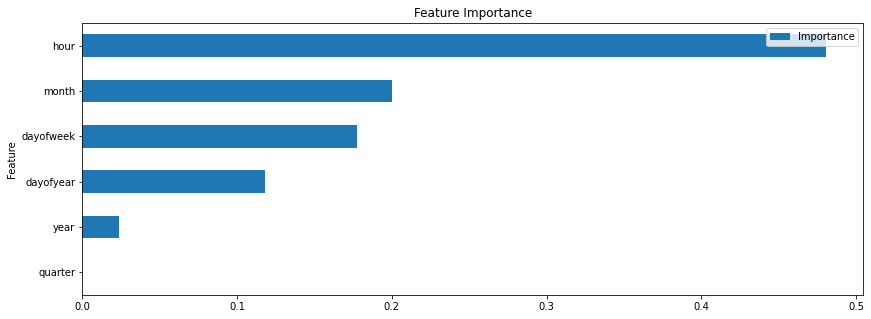

In [252]:
fig, ax = plt.subplots(figsize=(14,5))

plt.title('PJME Energy use in MW', fontsize=13)

f1.plot(
    ax = ax,
    kind='barh', 
    figsize=(14, 5),
    y='Importance', 
    x='Feature',
    title = 'Feature Importance'
)

ax.legend(loc='upper right')

plt.show()

## **Forecast**

In [256]:
test['prediction'] = reg.predict(X_test)

In [257]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

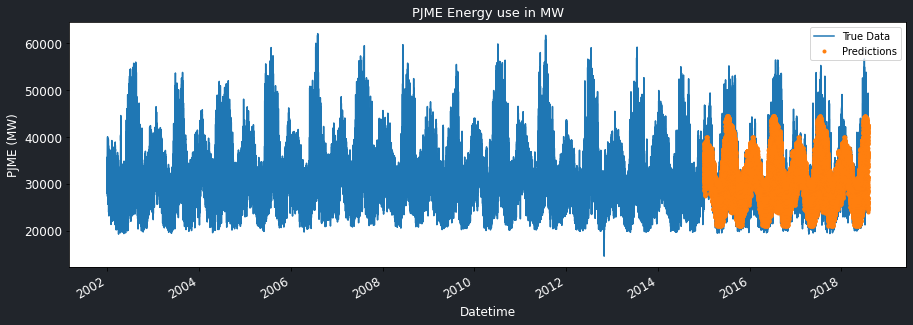

In [258]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.grid(visible=True, linewidth=0.1, color='black')
fig.patch.set_facecolor('#21252b') 

plt.title('PJME Energy use in MW', fontsize=13, color='white')

df[['PJME_MW']].plot(ax = ax, figsize=(15, 5))
df['prediction'].plot(ax = ax, style='.')

plt.legend(['True Data', 'Predictions'], loc='upper right')

plt.xlabel('Datetime', size=12, weight=400, color='white')
plt.xticks(color='white', size=12)

plt.ylabel('PJME (MW)', size=12, weight=400, color='white')
plt.yticks(color='white', size=12)

plt.show()

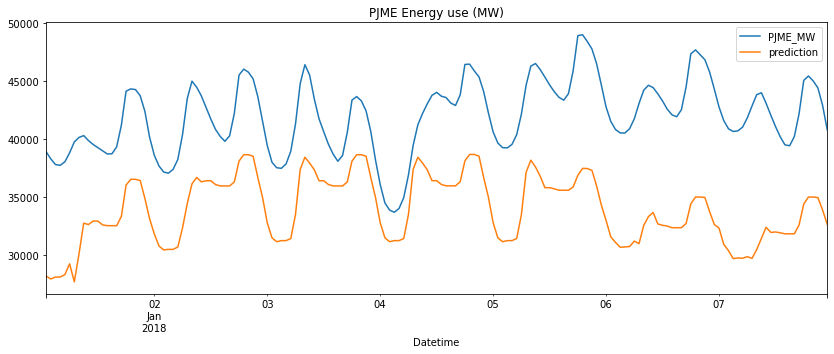

In [259]:
df_week = df[['PJME_MW', 'prediction']].query('index > "01/01/2018" & index < "01/08/2018"')

df_week.plot(
    figsize=(14, 5), 
    title='PJME Energy use (MW)'
)

plt.show()

In [262]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

In [264]:
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 3714.62


### **Calculate Error**

In [271]:
test['error'] = np.abs(test['PJME_MW'] - test['prediction'])

In [273]:
test['date'] = test.index.date

In [279]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    14559.813965
2016-08-14    14393.350830
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64